In [1]:
import pandas as pd                                       #importing pandas
import numpy as np                                        #importing numpy
import matplotlib.pyplot as plt                           #importing matplotlib 
import seaborn as sns                                     #importing seaborn
from sklearn.model_selection import train_test_split      #importing scikit-learn's function for data splitting
from sklearn.linear_model import LinearRegression         #importing scikit-learn's linear regressor function
from sklearn.neural_network import MLPRegressor           #importing scikit-learn's neural network function
from sklearn.ensemble import GradientBoostingRegressor    #importing scikit-learn's gradient booster regressor function
from sklearn.metrics import mean_squared_error            #importing scikit-learn's root mean squared error function for model evaluation
from sklearn.model_selection import cross_validate        #improting scikit-learn's cross validation function
import random
import time
from scipy.stats import ks_2samp, kruskal

In [2]:
boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #load boxscores dataset
# running locally
# boxscores = pd.read_csv('boxscores_dataset.csv')     #load boxscores dataset
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

Text(137.59722222222223, 0.5, 'Fantasy Points')

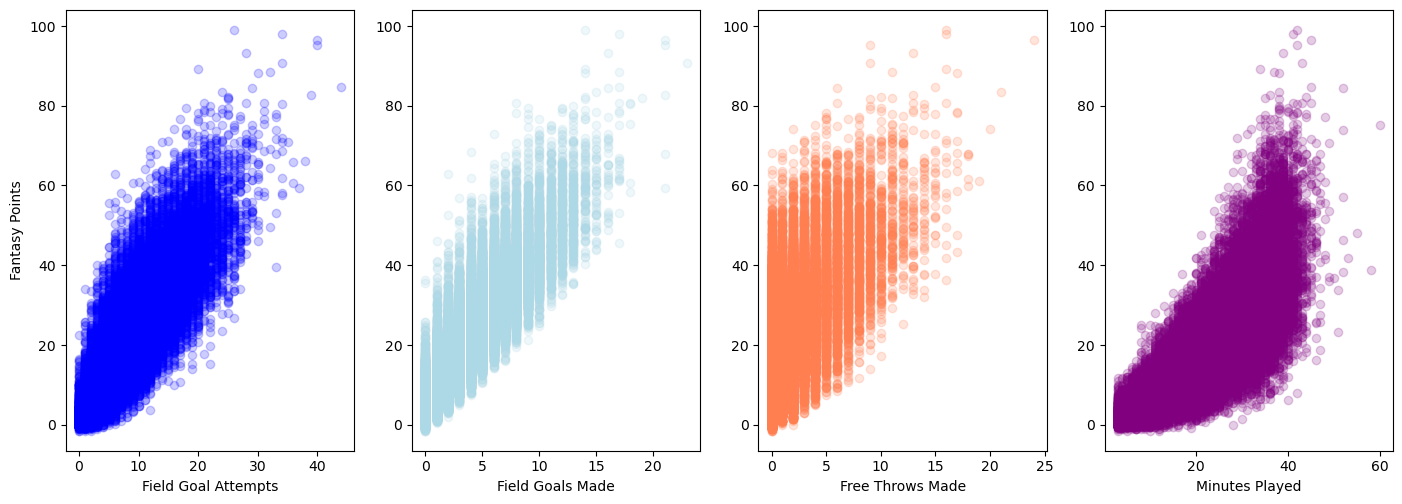

In [3]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Field Goal Attempts')
FGM.set_xlabel('Field Goals Made')
FTM.set_xlabel('Free Throws Made')
Min.set_xlabel('Minutes Played')

FGA.set_ylabel('Fantasy Points')

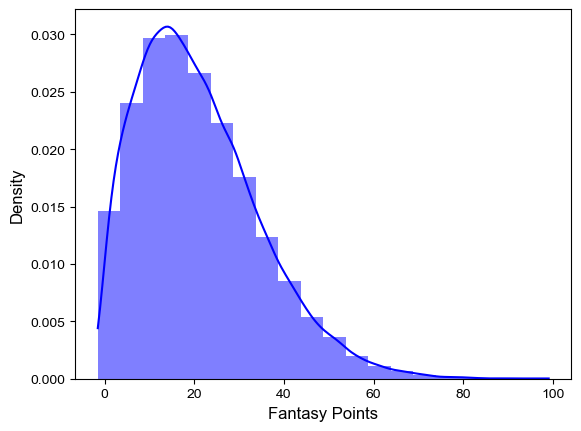

In [4]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

In [5]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
0             226  2016-10-26   8:00  Regular  Abrines  Alejandro      OKC   
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayBLK  movingpla

In [6]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)  

In [7]:
print(boxscores)

       Unnamed: 0      gmDate gmTime  seasTyp  playLNm    playFNm teamAbbr  \
2            1382  2016-11-02  10:30  Regular  Abrines  Alejandro      OKC   
3            1492  2016-11-03  10:30  Regular  Abrines  Alejandro      OKC   
4            1724  2016-11-05   6:00  Regular  Abrines  Alejandro      OKC   
5            2130  2016-11-07   8:00  Regular  Abrines  Alejandro      OKC   
6            2447  2016-11-09   8:00  Regular  Abrines  Alejandro      OKC   
...           ...         ...    ...      ...      ...        ...      ...   
36752       23335  2017-03-26   9:30  Regular    Zubac      Ivica      LAL   
36753       23622  2017-03-28  10:30  Regular    Zubac      Ivica      LAL   
36756       29682  2017-11-09   7:00  Regular    Zubac      Ivica      LAL   
36758       31582  2017-11-21  10:30  Regular    Zubac      Ivica      LAL   
36760       33441  2017-12-03   9:30  Regular    Zubac      Ivica      LAL   

      teamConf    teamDiv teamLoc  ... movingplayBLK  movingpla

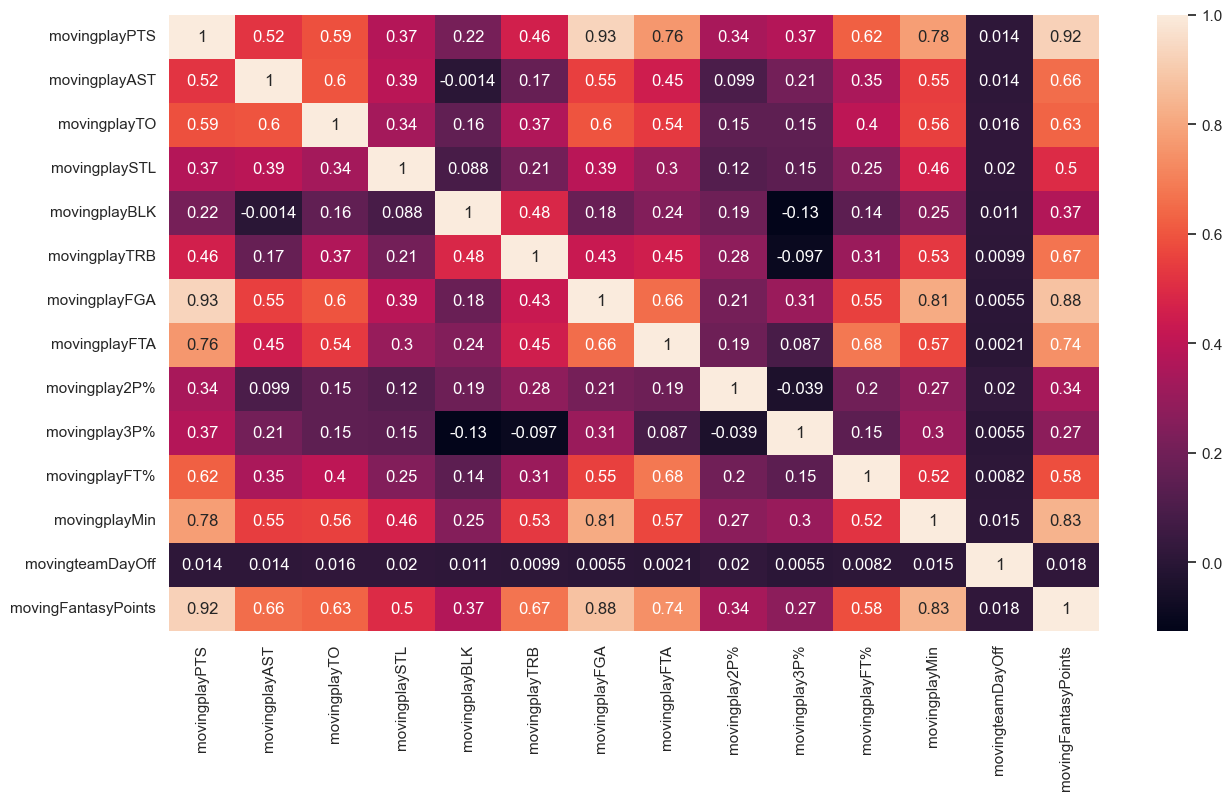

In [8]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

In [9]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1 if the game is a home game, 0 if it is an away game
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1 if the player starts, 0 if the player comes from the bench

In [10]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #for model training, we exclude observation on December 25, 2017

In [11]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #select the features that will be used for model training
y = forecasting_data['FantasyPoints']  #target set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #dataset splitting

linear_regressor = LinearRegression()                                                         #load linear regressor
linear_regressor.fit(X_train, y_train)                                                        #train the linear regression model
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #load neural network
mlp.fit(X_train,y_train)                                                                      #train the neural network with a ReLU function and two hidden layers with 5 nodes each
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #load a gradient boosting regressor
gb.fit(X_train, y_train)                                                                      #train a gradient boosting model
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

In [12]:
gb_validation['test_score']  

array([0.50927885, 0.4990288 , 0.48129381, 0.49758921, 0.50066995])

In [13]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #make predictions based on the test set for the linear regression model
mlp_predictions = mlp.predict(X_test)                                                         #make predictions based on the test set for the neural network model
gb_predictions = gb.predict(X_test)                                                           #make predictions based on the test set for the gradient boosting model

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #calculate the MSE for the linear regression model
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #calculate the MSE for the neural network model
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #calculate the MSE for the gradient boosting model

results = {'Linear Regression':[linear_regression_mse],'ReLU Neural Network':[mlp_mse],'Gradient Boosting Regressor':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,Linear Regression,ReLU Neural Network,Gradient Boosting Regressor
MSE,91.077312,91.087719,90.669304


Text(968.0882352941177, 0.5, 'Gradient Boosting Residual')

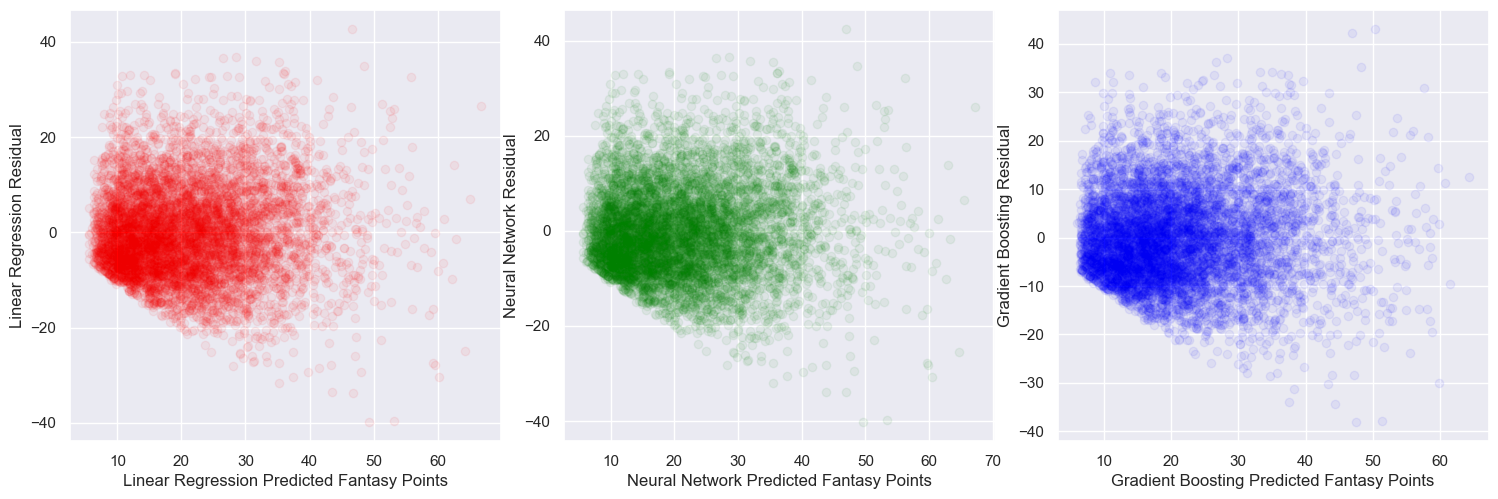

In [14]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear Regression Predicted Fantasy Points')
FNN.set_xlabel('Neural Network Predicted Fantasy Points')
GBR.set_xlabel('Gradient Boosting Predicted Fantasy Points')

LR.set_ylabel('Linear Regression Residual')
FNN.set_ylabel('Neural Network Residual')
GBR.set_ylabel('Gradient Boosting Residual')

In [15]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
# player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

In [16]:
print(player_results)

               Player Pos Team     Opp  Salary         playDispNm  \
0        James Harden  PG  HOU   @ OKC   11100       James Harden   
1        LeBron James  SF  CLE   @ GSW   11000       LeBron James   
2   Russell Westbrook  PG  OKC  vs HOU   10900  Russell Westbrook   
3        Kevin Durant  SF  GSW  vs CLE   10500       Kevin Durant   
4         Joel Embiid   C  PHI   @ NYK    9500        Joel Embiid   
..                ...  ..  ...     ...     ...                ...   
91       Andrew Bogut   C  LAL  vs MIN    3000       Andrew Bogut   
92        Alex Caruso  PG  LAL  vs MIN    3000        Alex Caruso   
93      Briante Weber  PG  HOU   @ OKC    3000      Briante Weber   
94         Cedi Osman  SG  CLE   @ GSW    3000         Cedi Osman   
95       Josh Huestis  SF  OKC  vs HOU    3000       Josh Huestis   

    PredictedFantasyPoints  
0                48.809577  
1                48.149718  
2                44.007224  
3                43.438575  
4                51.313689

In [17]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #we multiple the fantasy vs salary ratio by 1000 for better visualization
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


In [18]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000
positions = dict(zip(indices, player_results.Pos))

In [19]:
# Lista de posiciones que deben ser cubiertas en cada equipo
posiciones = ["C", "PG", "SG", "SF", "PF"] 
# Crear un diccionario con los jugadores agrupados por posición
jugadores_por_posicion = {pos: [nombre for nombre in indices if positions[nombre] == pos] 
                          for pos in posiciones}

## Definimos los parámetros

In [20]:
#número máximo de iteraciones (itera)
num_generaciones = 400
#tamaño de la población
tamanoPoblacion= 100
#tasa mutación
mu=0.2
# porcentaje de cruzamiento
pc = 0.5
# numero de hijos descencientes (nc)
num_equipos = 50
#número de descendientes mutados
nm=round(0.3*tamanoPoblacion)   

## Definimos las funciones

### Fitness
Aquí ya iría incluido el límite de que el salario no puede ser mayor que S, así que no lo tenemos que tener en cuenta más tarde

In [23]:
def calcular_fitness(row):
    """
    Calcula el fitness de un equipo basado en la suma de los puntos de los jugadores seleccionados.
    Penaliza si el presupuesto excede el máximo permitido.
    """
    puntos_totales = 0
    salario_total = 0
    
    for pos in posiciones:
        jugador = row[pos]  # Obtiene el nombre del jugador en la posición 'pos'
        puntos_totales += points[jugador]  # Suma los puntos del jugador
        salario_total += salaries[jugador]  # Suma el salario del jugador
    
    if salario_total > S:
        return 0  # Penalización si el equipo excede el presupuesto
    else:
        return puntos_totales

### Creacion la población

In [24]:
def creacion_poblacion(tamanoPoblacion):
    """
    Crea una población de equipos con jugadores aleatorios asignados a cada posición.
    """
    # Crear el DataFrame de la población
    pob = pd.DataFrame(index=range(tamanoPoblacion))
    pob['Equipo'] = range(0, tamanoPoblacion)
    
    # Asignar jugadores aleatorios a cada posición en el equipo
    for pos in posiciones:
        pob[pos] = [random.choice(jugadores_por_posicion[pos]) for _ in range(tamanoPoblacion)]
    
    # Calcular el fitness de cada equipo
    pob['Fitness'] = pob.apply(calcular_fitness, axis=1)
    
    return pob

### Seleccion
Más cómodo que como estaba implementada con cumsum, que también está basada en ruleta

In [25]:
def seleccion_ruleta(poblacion_df):
    """
    Selecciona dos padres basados en el fitness (ruleta).
    
    :param poblacion_df: DataFrame que contiene la población de equipos
    :return: Dos padres seleccionados de la población
    """
    fitness_vals = poblacion_df["Fitness"].values
    total_fitness = sum(fitness_vals)

    if total_fitness == 0:
        return poblacion_df.sample(n=2).iloc[:2].to_dict("records")  # Evita división por cero y selecciona aleatoriamente

    # Calcular las probabilidades basadas en el fitness
    probabilidades = [f / total_fitness for f in fitness_vals]

    # Selección del primer padre
    padre_1 = poblacion_df.sample(n=1, weights=probabilidades).iloc[0]

    # Selección del segundo padre
    padre_2 = poblacion_df.sample(n=1, weights=probabilidades).iloc[0]

    return padre_1, padre_2

### Cruce: intercambiar jugadores
La clave ha sido coger el máximo entre los puntos de los padres para pasar esa cualidad al hijo.
En otra versión simplemente intercambiaba de manera random ambos, pero no me convergía. Ahora converge y más rápido.

In [26]:
def cruce(padre1, padre2, pc):
    """
    Intercambia aleatoriamente jugadores entre los equipos manteniendo restricciones.
    """
    hijo1, hijo2 = padre1.copy(), padre2.copy()  # Asegúrate de copiar las estructuras

    for pos in posiciones:
        if random.random() > pc:  
            if points[hijo1[pos]] > points[hijo2[pos]]:
                hijo2[pos] = hijo1[pos]
            else:
                hijo1[pos] = hijo2[pos]
    
    return hijo1, hijo2


### Mutación: cambiar un jugador aleatoriamente

In [27]:
def mutacion(equipo,mu):
    """
    Cambia aleatoriamente un jugador en una posición con probabilidad tasa_mutacion.
    """
    for pos in posiciones:
        if random.random() < mu:
            equipo[pos] = random.choice(jugadores_por_posicion[pos]) 
    
    return equipo


## Implementación GA

In [28]:
# Inicialización de la población
poblacion_df = creacion_poblacion(tamanoPoblacion)

# Bucle principal
for gen in range(num_generaciones):
    
    # Hacer una copia de la población para trabajar en ella sin alterar la original
    P = poblacion_df.copy()
    nueva_poblacion = []
    
    # Realizar cruce para obtener nuevos hijos
    for j in range(num_equipos // 2):  # Cruce en pares
        # Selección de los padres
        padre1, padre2 = seleccion_ruleta(P)
        
        # Realización del cruce
        hijo1, hijo2 = cruce(padre1, padre2, pc)

        # Calcular el fitness de los hijos
        hijo1['Fitness'] = calcular_fitness(hijo1)
        hijo2['Fitness'] = calcular_fitness(hijo2)

        nueva_poblacion.append(hijo1)
        nueva_poblacion.append(hijo2)
        

    # Aplicar la mutación a una fracción de la población
    for k in range(nm):
        z = random.randint(0, len(nueva_poblacion)-1)
        hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
        hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
        nueva_poblacion[z] = hijo_mutado
        
    # Convertir la lista de nueva población a un DataFrame
    nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
    
    # Concatenar la nueva población con la población existente (actualizar poblacion_df)
    poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
    
    poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
    
    # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
    # Otra forma sería que los hijos reemplacen a los padres
    poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
    
    mejor = poblacion_df.iloc[0]
    
    #print("mejor equipo en iteracion ", gen, mejor['Fitness'])

# Mostrar el mejor equipo encontrado
mejor_equipo = poblacion_df.sort_values(by="Fitness", ascending=False).iloc[0]
print("Mejor equipo encontrado:\n", mejor_equipo)

Mejor equipo encontrado:
 Equipo               67
C           Joel Embiid
PG            Josh Hart
SG         Trevor Ariza
SF          Paul George
PF          Jordan Bell
Fitness      171.411918
Name: 0, dtype: object


## Resultado final

In [29]:
print("\nEquipo óptimo seleccionado:")
for pos in posiciones:
    jugador = mejor_equipo[pos]
    print(f"{jugador} - Posición: {pos}, FantasyPoints: {points[jugador]}, Salary: {salaries[jugador]}")


Equipo óptimo seleccionado:
Joel Embiid - Posición: C, FantasyPoints: 51.31368913047382, Salary: 9500
Josh Hart - Posición: PG, FantasyPoints: 24.26256418841442, Salary: 3700
Trevor Ariza - Posición: SG, FantasyPoints: 26.354156526577885, Salary: 5000
Paul George - Posición: SF, FantasyPoints: 36.398212282625806, Salary: 6800
Jordan Bell - Posición: PF, FantasyPoints: 33.08329620978338, Salary: 4900


In [30]:
results['True Fantasy Points'] = [53.5,17.25,28.5,15.5,29.25]
results

{'Linear Regression': [91.07731216428819],
 'ReLU Neural Network': [91.08771916279446],
 'Gradient Boosting Regressor': [90.66930378998275],
 'True Fantasy Points': [53.5, 17.25, 28.5, 15.5, 29.25]}

# Pruebas estadísticas

Comenzamos por el tamaño de la población. Para ello modificaremos el código del bucle principal para realizar los análisis de manera automatizada

Parámetros del experimento:

In [ ]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 600

#tamaño de la población
tamano_poblacion_values = np.linspace(10, 400, 6, dtype=int)

# Número de muestras para cada tamaño de población
num_pruebas = 50  

Ahora el código

In [ ]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for tamano_poblacion in tamano_poblacion_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        poblacion_df = creacion_poblacion(tamano_poblacion)
        start_time = time.time()
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, pc)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
            
            # Si el fitness alcanzó el valor objetivo, finalizar la iteración
            if mejor['Fitness'] >= 171.918929:  # Solución ideal
                break
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'tamano_poblacion': tamano_poblacion,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_tamano_poblacion_10_400_30_50.csv', index=False)

# Análisis estadístico (usando Kruskal-Wallis)
# Primero, agrupamos los resultados por tamaño de población
grouped_results = df_resultados.groupby('tamano_poblacion')['mejor_fitness'].apply(list)

# Realizar el test de Kruskal-Wallis
stat, p_valor = kruskal(*grouped_results)

print(f"Estadística de Kruskal-Wallis: {stat}, p-valor: {p_valor}")

In [ ]:
# Leer los datos desde el archivo CSV
df = pd.read_csv('resultados_tamano_poblacion_10_400_30_50.csv')

# Cálculos estadísticos por tamaño de población
estadisticas = df.groupby('tamano_poblacion').agg(
    media_fitness=('mejor_fitness', 'mean'),
    mediana_fitness=('mejor_fitness', 'median'),
    cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
    cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
    media_iteraciones=('iteraciones', 'mean'),
    mediana_iteraciones=('iteraciones', 'median'),
    cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
    cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
    media_tiempo=('tiempo', 'mean'),
    mediana_tiempo=('tiempo', 'median'),
    cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
    cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
)

# Mostrar las estadísticas
print("\nEstadísticas por tamaño de población:")
print(estadisticas)

In [ ]:
# Filtrar los datos donde el número de iteraciones es igual a 599
df_599_iteraciones = df[df['iteraciones'] == 599]

# Contar cuántas veces ocurre 599 iteraciones para cada tamaño de población
conteo_599 = df_599_iteraciones.groupby('tamano_poblacion').size()

# Mostrar los resultados
print("Conteo de iteraciones 599 por tamaño de población:")
print(conteo_599)

Ahora vemos que < 160 y > 160 sea estadisticamente independiente

In [ ]:
# Filtrar los datos para obtener los dos grupos: iteraciones < 160 y iteraciones > 160
grupo_menor_160 = df[df['tamano_poblacion'] < 160]['iteraciones']
grupo_mayor_160_menor_300 = df[(df['tamano_poblacion'] > 160) & (df['tamano_poblacion'] < 300)]['iteraciones']
grupo_mayor_300 = df[(df['tamano_poblacion'] > 300)]['iteraciones']

# Aplicar la prueba de Kolmogórov-Smirnov (K-S) para comparar las dos primeras distribuciones
stat_ks, p_value_ks = ks_2samp(grupo_menor_160, grupo_mayor_160_menor_300)

print('prueba 1')
print(f"p-valor: {p_value_ks}")

if p_value_ks < 0.05:
    print("Rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 son significativamente diferentes.")
else:
    print("No rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 no son significativamente diferentes.")



# Aplicar la prueba de Kolmogórov-Smirnov (K-S) para comparar las dos últimas distribuciones
stat_ks, p_value_ks = ks_2samp(grupo_mayor_300, grupo_mayor_160_menor_300)

print('prueba 2')
print(f"p-valor: {p_value_ks}")

if p_value_ks < 0.05:
    print("Rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 son significativamente diferentes.")
else:
    print("No rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 no son significativamente diferentes.")


ahora vemos que > 160 y < 300 sea dependiente

In [ ]:
# Filtrar los datos para tamaños de población mayores a 160
grupo_mayor_160 = df[(df['tamano_poblacion'] > 160) & (df['tamano_poblacion'] < 300)]

# Agrupar los datos por tamaño de población mayor a 160 y obtener las iteraciones correspondientes
grupos_iteraciones = [grupo_mayor_160[grupo_mayor_160['tamano_poblacion'] == size]['iteraciones'].values for size in grupo_mayor_160['tamano_poblacion'].unique()]


# Aplicar la prueba de Kruskal-Wallis para comparar las distribuciones de iteraciones entre diferentes tamaños de población
stat_kw, p_value_kw = kruskal(*grupos_iteraciones)

# Mostrar el resultado de la prueba Kruskal-Wallis
print(f"Estadística de Kruskal-Wallis: {stat_kw}")
print(f"p-valor: {p_value_kw}")

# Evaluar si existe una diferencia significativa
if p_value_kw < 0.05:
    print("Rechazamos la hipótesis nula: hay diferencias significativas entre las distribuciones de las iteraciones para los diferentes tamaños de población mayores a 160.")
else:
    print("No rechazamos la hipótesis nula: no hay diferencias significativas entre las distribuciones de las iteraciones para los diferentes tamaños de población mayores a 160.")


Fijamos pues el intervalo en [160, 300] tomamos pues por ejemplo 250

# Realizamos lo mismo pero para PC, probabilidad de cruzamiento

In [ ]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 600

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
pc_values = np.linspace(0.01, 0.99, 10, dtype=float)

In [ ]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for pc in pc_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        poblacion_df = creacion_poblacion(tamano_poblacion)
        start_time = time.time()
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, pc)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
            
            # Si el fitness alcanzó el valor objetivo, finalizar la iteración
            if mejor['Fitness'] >= 171.918929:  # Solución ideal
                break
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'pc': pc,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_pc_01_99_10_50.csv', index=False)

In [ ]:
# Leer los datos desde el archivo CSV
df = pd.read_csv('resultados_pc_01_99_10_50.csv')

# Cálculos estadísticos por tamaño de población
estadisticas = df.groupby('pc').agg(
    media_fitness=('mejor_fitness', 'mean'),
    mediana_fitness=('mejor_fitness', 'median'),
    cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
    cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
    media_iteraciones=('iteraciones', 'mean'),
    mediana_iteraciones=('iteraciones', 'median'),
    cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
    cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
    media_tiempo=('tiempo', 'mean'),
    mediana_tiempo=('tiempo', 'median'),
    cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
    cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
)

# Mostrar las estadísticas
print("\nEstadísticas por tamaño de población:")
print(estadisticas)

In [ ]:
# Filtrar los datos donde el número de iteraciones es igual a 599
df_599_iteraciones = df[df['iteraciones'] == 599]

# Contar cuántas veces ocurre 599 iteraciones para cada tamaño de población
conteo_599 = df_599_iteraciones.groupby('pc').size()

# Mostrar los resultados
print("Conteo de iteraciones 599 por tamaño de población:")
print(conteo_599)

In [ ]:
# Filtrar los datos para obtener los dos grupos: iteraciones < 160 y iteraciones > 160
grupo_menor_15 = df[df['pc'] < 0.15]['iteraciones']
grupo_mayor_15_menor_4 = df[(df['pc'] > 0.15) & (df['pc'] < 0.4)]['iteraciones']
grupo_mayor_4 = df[(df['pc'] > 0.4)]['iteraciones']

# Aplicar la prueba de Kolmogórov-Smirnov (K-S) para comparar las dos primeras distribuciones
stat_ks, p_value_ks = ks_2samp(grupo_menor_15, grupo_mayor_15_menor_4)

print('prueba 1')
print(f"p-valor: {p_value_ks}")

if p_value_ks < 0.05:
    print("Rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 son significativamente diferentes.")
else:
    print("No rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 no son significativamente diferentes.")



# Aplicar la prueba de Kolmogórov-Smirnov (K-S) para comparar las dos últimas distribuciones
stat_ks, p_value_ks = ks_2samp(grupo_mayor_4, grupo_mayor_15_menor_4)

print('prueba 2')
print(f"p-valor: {p_value_ks}")

if p_value_ks < 0.05:
    print("Rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 son significativamente diferentes.")
else:
    print("No rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 no son significativamente diferentes.")


In [ ]:
# Filtrar los datos para tamaños de población mayores a 160
grupo_mayor_15_menor_4 = df[(df['pc'] > 0.15) & (df['pc'] < 0.4)]

# Agrupar los datos por tamaño de población mayor a 160 y obtener las iteraciones correspondientes
grupos_iteraciones = [grupo_mayor_15_menor_4[grupo_mayor_15_menor_4['pc'] == size]['iteraciones'].values for size in grupo_mayor_15_menor_4['pc'].unique()]


# Aplicar la prueba de Kruskal-Wallis para comparar las distribuciones de iteraciones entre diferentes tamaños de población
stat_kw, p_value_kw = kruskal(*grupos_iteraciones)

# Mostrar el resultado de la prueba Kruskal-Wallis
print(f"Estadística de Kruskal-Wallis: {stat_kw}")
print(f"p-valor: {p_value_kw}")

# Evaluar si existe una diferencia significativa
if p_value_kw < 0.05:
    print("Rechazamos la hipótesis nula: hay diferencias significativas entre las distribuciones de las iteraciones para los diferentes tamaños de población mayores a 160.")
else:
    print("No rechazamos la hipótesis nula: no hay diferencias significativas entre las distribuciones de las iteraciones para los diferentes tamaños de población mayores a 160.")


In [ ]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones = 600

#tamaño de la población
pc = 0.3

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
mu_values = np.linspace(0.01, 0.99, 10, dtype=float)

In [ ]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for mu in mu_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        poblacion_df = creacion_poblacion(tamano_poblacion)
        start_time = time.time()
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, pc)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
            
            # Si el fitness alcanzó el valor objetivo, finalizar la iteración
            if mejor['Fitness'] >= 171.918929:  # Solución ideal
                break
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'mu': mu,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_mu_01_99_10_50.csv', index=False)

In [ ]:
# Leer los datos desde el archivo CSV
df = pd.read_csv('resultados_mu_01_99_10_50.csv')

# Cálculos estadísticos por tamaño de población
estadisticas = df.groupby('mu').agg(
    media_fitness=('mejor_fitness', 'mean'),
    mediana_fitness=('mejor_fitness', 'median'),
    cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
    cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
    media_iteraciones=('iteraciones', 'mean'),
    mediana_iteraciones=('iteraciones', 'median'),
    cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
    cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
    media_tiempo=('tiempo', 'mean'),
    mediana_tiempo=('tiempo', 'median'),
    cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
    cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
)

# Mostrar las estadísticas
print("\nEstadísticas por tamaño de población:")
print(estadisticas)

Valor ideal: entre 0.1 y 0.4

In [ ]:
# Filtrar los datos donde el número de iteraciones es igual a 599
df_599_iteraciones = df[df['iteraciones'] == 599]

# Contar cuántas veces ocurre 599 iteraciones para cada tamaño de población
conteo_599 = df_599_iteraciones.groupby('mu').size()

# Mostrar los resultados
print("Conteo de iteraciones 599 por tamaño de población:")
print(conteo_599)

In [ ]:
# Filtrar los datos para obtener los dos grupos: iteraciones < 160 y iteraciones > 160
grupo_menor_1 = df[df['mu'] < 0.1]['iteraciones']
grupo_mayor_1_menor_4 = df[(df['mu'] > 0.1) & (df['mu'] < 0.4)]['iteraciones']
grupo_mayor_4 = df[(df['mu'] > 0.4)]['iteraciones']

# Aplicar la prueba de Kolmogórov-Smirnov (K-S) para comparar las dos primeras distribuciones
stat_ks, p_value_ks = ks_2samp(grupo_menor_1, grupo_mayor_1_menor_4)

print('prueba 1')
print(f"p-valor: {p_value_ks}")

if p_value_ks < 0.05:
    print("Rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 son significativamente diferentes.")
else:
    print("No rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 no son significativamente diferentes.")



# Aplicar la prueba de Kolmogórov-Smirnov (K-S) para comparar las dos últimas distribuciones
stat_ks, p_value_ks = ks_2samp(grupo_mayor_4, grupo_mayor_1_menor_4)

print('prueba 2')
print(f"p-valor: {p_value_ks}")

if p_value_ks < 0.05:
    print("Rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 son significativamente diferentes.")
else:
    print("No rechazamos la hipótesis nula: las distribuciones de iteraciones menores a 160 y mayores a 160 no son significativamente diferentes.")


In [ ]:
# Filtrar los datos para tamaños de población mayores a 160
grupo_mayor_1_menor_4 = df[(df['mu'] > 0.15) & (df['mu'] < 0.4)]

# Agrupar los datos por tamaño de población mayor a 160 y obtener las iteraciones correspondientes
grupos_iteraciones = [grupo_mayor_1_menor_4[grupo_mayor_1_menor_4['mu'] == size]['iteraciones'].values for size in grupo_mayor_1_menor_4['mu'].unique()]


# Aplicar la prueba de Kruskal-Wallis para comparar las distribuciones de iteraciones entre diferentes tamaños de población
stat_kw, p_value_kw = kruskal(*grupos_iteraciones)

# Mostrar el resultado de la prueba Kruskal-Wallis
print(f"Estadística de Kruskal-Wallis: {stat_kw}")
print(f"p-valor: {p_value_kw}")

# Evaluar si existe una diferencia significativa
if p_value_kw < 0.05:
    print("Rechazamos la hipótesis nula: hay diferencias significativas entre las distribuciones de las iteraciones para los diferentes tamaños de población mayores a 160.")
else:
    print("No rechazamos la hipótesis nula: no hay diferencias significativas entre las distribuciones de las iteraciones para los diferentes tamaños de población mayores a 160.")


In [31]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones_values = np.linspace(40, 600, 10, dtype=int)

#tamaño de la población
pc = 0.3

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
mu_values = 0.3

veamos cuantas iteraciones necesitamos

In [32]:
# Almacenamiento de resultados
resultados = []

# Bucle para probar cada tamaño de población
for num_generaciones in num_generaciones_values:
    for prueba in range(num_pruebas):
        # Inicializar la población
        poblacion_df = creacion_poblacion(tamano_poblacion)
        start_time = time.time()
        
        # Bucle principal de generaciones
        for gen in range(num_generaciones):
            P = poblacion_df.copy()
            nueva_poblacion = []
            
            # Realizar cruce y mutación (como en el código original)
            # Realizar cruce para obtener nuevos hijos
            for j in range(num_equipos // 2):  # Cruce en pares
                # Selección de los padres
                padre1, padre2 = seleccion_ruleta(P)
                
                # Realización del cruce
                hijo1, hijo2 = cruce(padre1, padre2, pc)

                # Calcular el fitness de los hijos
                hijo1['Fitness'] = calcular_fitness(hijo1)
                hijo2['Fitness'] = calcular_fitness(hijo2)

                nueva_poblacion.append(hijo1)
                nueva_poblacion.append(hijo2)
                

            # Aplicar la mutación a una fracción de la población
            for k in range(nm):
                z = random.randint(0, len(nueva_poblacion)-1)
                hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
                hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
                nueva_poblacion[z] = hijo_mutado
                
            # Convertir la lista de nueva población a un DataFrame
            nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
            
            # Concatenar la nueva población con la población existente (actualizar poblacion_df)
            poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
            
            poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
            
            # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
            # Otra forma sería que los hijos reemplacen a los padres
            poblacion_df=poblacion_df.iloc[0:tamanoPoblacion]
            
            # Verificar el mejor fitness al final de cada generación
            mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual
        
        # Tiempo de ejecución
        tiempo_ejecucion = time.time() - start_time
        resultados.append({
            'num_generaciones': num_generaciones,
            'prueba': prueba,
            'mejor_fitness': mejor['Fitness'],
            'iteraciones': gen,
            'tiempo': tiempo_ejecucion
        })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_num_generaciones_1_99_10_50.csv', index=False)

In [33]:
# Leer los datos desde el archivo CSV
df = pd.read_csv('resultados_num_generaciones_1_99_10_50.csv')

# Cálculos estadísticos por tamaño de población
estadisticas = df.groupby('num_generaciones').agg(
    media_fitness=('mejor_fitness', 'mean'),
    mediana_fitness=('mejor_fitness', 'median'),
    cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
    cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
    media_iteraciones=('iteraciones', 'mean'),
    mediana_iteraciones=('iteraciones', 'median'),
    cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
    cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
    media_tiempo=('tiempo', 'mean'),
    mediana_tiempo=('tiempo', 'median'),
    cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
    cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
)

# Mostrar las estadísticas
print("\nEstadísticas por tamaño de población:")
print(estadisticas)


Estadísticas por tamaño de población:
                  media_fitness  mediana_fitness  cuartil_25_fitness  cuartil_75_fitness  media_iteraciones  mediana_iteraciones  cuartil_25_iteraciones  cuartil_75_iteraciones  media_tiempo  mediana_tiempo  cuartil_25_tiempo  cuartil_75_tiempo
num_generaciones                                                                                                                                                                                                                                    
40                   171.439051       171.918929          171.918929          171.918929               39.0                 39.0                    39.0                    39.0      1.737782        1.699361           1.584377           1.820989
102                  171.495660       171.918929          171.918929          171.918929              101.0                101.0                   101.0                   101.0      4.358005        4.243862           4.087988 

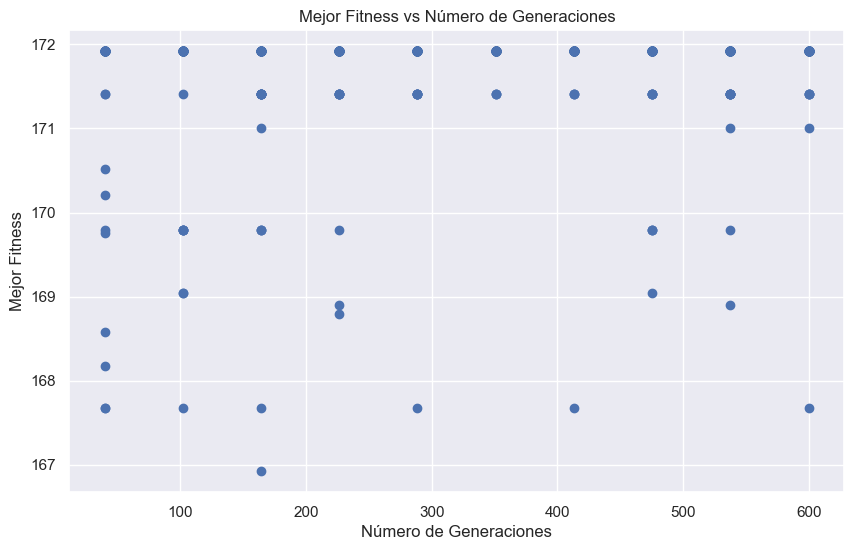

In [34]:
# Cargar el archivo CSV
df_resultados = pd.read_csv('resultados_num_generaciones_1_99_10_50.csv')

# Crear el gráfico de dispersión
plt.figure(figsize=(10,6))
plt.scatter(df_resultados['num_generaciones'], df_resultados['mejor_fitness'])
plt.title('Mejor Fitness vs Número de Generaciones')
plt.xlabel('Número de Generaciones')
plt.ylabel('Mejor Fitness')
plt.grid(True)
plt.show()


350 generaciones

para que el tiempo no sea una barbaridad, vamos a poner que si en 20 generaciones el resultado no cambia que entonces pare

In [35]:
# Lo ponemos en 600. Así si el experimento termina puede ser porque
# la población es demasiado pequeña y no se llega al valor óptimo
# la población es demasiado grande y el tiempo de ejecución entra
# en juego
num_generaciones_values = 350

#tamaño de la población
pc = 0.3

#tamaño de la población
tamano_poblacion = 250

# Número de muestras para cada tamaño de población
num_pruebas = 50  

# porcentaje de cruzamiento
mu_values = 0.3

In [74]:
# Almacenamiento de resultados
resultados = []

for prueba in range(num_pruebas):
    # Inicializar la población
    poblacion_df = creacion_poblacion(tamano_poblacion)
    start_time = time.time()

    # Bucle principal de generaciones
    mejor_fitness_antiguo = None
    iteraciones_sin_cambio = 0
    
    for gen in range(num_generaciones):
        P = poblacion_df.copy()
        nueva_poblacion = []
        
        # Realizar cruce y mutación (como en el código original)
        # Realizar cruce para obtener nuevos hijos
        for j in range(num_equipos // 2):  # Cruce en pares
            # Selección de los padres
            padre1, padre2 = seleccion_ruleta(P)
            
            # Realización del cruce
            hijo1, hijo2 = cruce(padre1, padre2, pc)

            # Calcular el fitness de los hijos
            hijo1['Fitness'] = calcular_fitness(hijo1)
            hijo2['Fitness'] = calcular_fitness(hijo2)

            nueva_poblacion.append(hijo1)
            nueva_poblacion.append(hijo2)
        
        # Aplicar la mutación a una fracción de la población
        for k in range(nm):
            z = random.randint(0, len(nueva_poblacion)-1)
            hijo_mutado = mutacion(nueva_poblacion[z].copy(),mu)
            hijo_mutado['Fitness'] = calcular_fitness(hijo_mutado)
            nueva_poblacion[z] = hijo_mutado

        # Convertir la lista de nueva población a un DataFrame
        nueva_poblacion_df = pd.DataFrame(nueva_poblacion)
        
        # Concatenar la nueva población con la población existente (actualizar poblacion_df)
        poblacion_df = pd.concat([poblacion_df, nueva_poblacion_df], ignore_index=True)
        
        poblacion_df = poblacion_df.sort_values(by="Fitness", ascending=False)
        
        # Cogemos los 50 primeros de la pob ordenada y de Costs (fitness ordenado)
        poblacion_df = poblacion_df.iloc[0:tamanoPoblacion]
        
        # Verificar el mejor fitness al final de cada generación
        mejor = poblacion_df.iloc[0]  # Este es el mejor fitness en la generación actual

        # Verificar si el mejor fitness ha cambiado
        if mejor_fitness_antiguo is not None and mejor['Fitness'] == mejor_fitness_antiguo:
            iteraciones_sin_cambio += 1
        else:
            iteraciones_sin_cambio = 0
        
        mejor_fitness_antiguo = mejor['Fitness']
        
        # Si el mejor fitness no ha cambiado en 20 generaciones, detener el bucle
        if iteraciones_sin_cambio >= 40:
            print(f"Terminando la prueba {prueba} en la generación {gen} debido a convergencia.")
            break

    # Tiempo de ejecución
    tiempo_ejecucion = time.time() - start_time
    resultados.append({
        'prueba': prueba,
        'mejor_fitness': mejor['Fitness'],
        'iteraciones': gen,
        'tiempo': tiempo_ejecucion
    })

# Convertir los resultados en un DataFrame para análisis posterior
df_resultados = pd.DataFrame(resultados)

# Guardar los resultados en un archivo CSV
df_resultados.to_csv('resultados_num_generaciones_350_tiempo.csv', index=False)


Terminando la prueba 0 en la generación 64 debido a convergencia.
Terminando la prueba 1 en la generación 50 debido a convergencia.
Terminando la prueba 2 en la generación 60 debido a convergencia.
Terminando la prueba 3 en la generación 64 debido a convergencia.
Terminando la prueba 4 en la generación 55 debido a convergencia.
Terminando la prueba 5 en la generación 71 debido a convergencia.
Terminando la prueba 6 en la generación 52 debido a convergencia.
Terminando la prueba 7 en la generación 51 debido a convergencia.
Terminando la prueba 8 en la generación 54 debido a convergencia.
Terminando la prueba 9 en la generación 58 debido a convergencia.
Terminando la prueba 10 en la generación 59 debido a convergencia.
Terminando la prueba 11 en la generación 50 debido a convergencia.
Terminando la prueba 12 en la generación 56 debido a convergencia.
Terminando la prueba 13 en la generación 82 debido a convergencia.
Terminando la prueba 14 en la generación 67 debido a convergencia.
Termi

In [75]:
# Leer los datos desde el archivo CSV
df = pd.read_csv('resultados_num_generaciones_350_tiempo.csv')

# Realizamos el cálculo estadístico para todas las filas (sin depender del índice)
estadisticas_fitness = df.agg(
    media_fitness=('mejor_fitness', 'mean'),
    mediana_fitness=('mejor_fitness', 'median'),
    cuartil_25_fitness=('mejor_fitness', lambda x: x.quantile(0.25)),
    cuartil_75_fitness=('mejor_fitness', lambda x: x.quantile(0.75)),
)

estadisticas_iteraciones = df.agg(
    media_iteraciones=('iteraciones', 'mean'),
    mediana_iteraciones=('iteraciones', 'median'),
    cuartil_25_iteraciones=('iteraciones', lambda x: x.quantile(0.25)),
    cuartil_75_iteraciones=('iteraciones', lambda x: x.quantile(0.75)),
)

estadisticas_tiempo = df.agg(
    media_tiempo=('tiempo', 'mean'),
    mediana_tiempo=('tiempo', 'median'),
    cuartil_25_tiempo=('tiempo', lambda x: x.quantile(0.25)),
    cuartil_75_tiempo=('tiempo', lambda x: x.quantile(0.75))
)

# Mostrar las estadísticas globales
print("\nEstadísticas globales:")
print(estadisticas_fitness, "\n\n", estadisticas_iteraciones, "\n\n", estadisticas_tiempo)


Estadísticas globales:
                    mejor_fitness
media_fitness          171.582093
mediana_fitness        171.918929
cuartil_25_fitness     171.918929
cuartil_75_fitness     171.918929 

                         iteraciones
media_iteraciones             57.04
mediana_iteraciones           55.00
cuartil_25_iteraciones        51.00
cuartil_75_iteraciones        60.00 

                      tiempo
media_tiempo       4.308428
mediana_tiempo     3.734542
cuartil_25_tiempo  3.187906
cuartil_75_tiempo  5.440047


veamos le porcentaje de veces que da el resultao correcto en este caso

In [84]:
# Calcular cuántas veces el mejor_fitness es igual a 91
igual_171 = df[df['mejor_fitness'] >= 171.918]
veces_igual_91 = len(igual_171)

# Mostrar el resultado
print(f"El mejor_fitness es igual a 171.918 en {veces_igual_91} ocasiones de 50.")


El mejor_fitness es igual a 171.918 en 41 ocasiones de 50.
